In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/miniconda3/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/miniconda3/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
import sys
sys.path.insert(0, '../../')
from src.discoverers.adsorption.randomsearch_nullmodel import RandomSearcherNullModel


# Initialize
discoverer = RandomSearcherNullModel(target_energy=target_energy,
                                     quantile_cutoff=quantile_cutoff,
                                     batch_size=batch_size,
                                     training_features=training_features,
                                     training_labels=training_labels,
                                     training_surfaces=training_surfaces,
                                     sampling_features=sampling_features,
                                     sampling_labels=sampling_labels,
                                     sampling_surfaces=sampling_surfaces,
                                     init_train=False  # Set to `False` only for warm starts
                                    )

## Run

In [5]:
discoverer.simulate_discovery()

In [ ]:
# Or load the last run
discoverer.load_last_run()

## Analyze

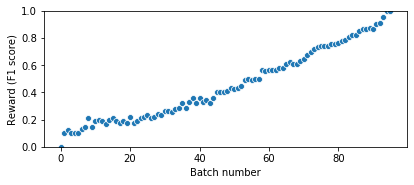

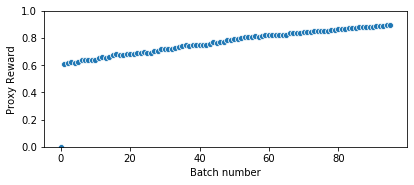

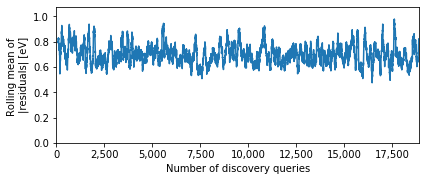

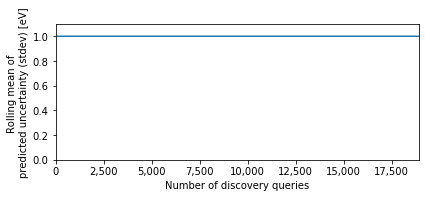

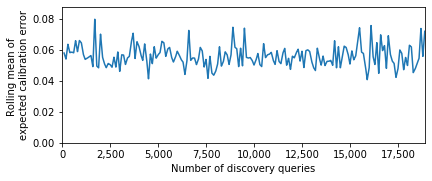

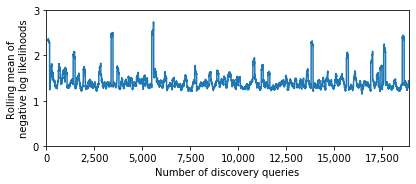

In [6]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)